In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

np.random.seed(42)

df = pd.read_csv('./data/modelling/final_dataset.csv')
df_meta = pd.read_csv('./data/modelling/final_dataset_meta.csv')

In [2]:
seasons = df_meta['Season']
X = df.drop('TeamA_Won', axis=1)
y = df['TeamA_Won']

model_features = [col for col in X.columns]
model_features

['diff_NetRating',
 'diff_normalized_ranking_strength',
 'diff_RegularSeasonWinPct',
 'diff_TournamentWinPct',
 'diff_TournamentGames',
 'diff_eFG_Pct',
 'diff_AssistToTurnover',
 'diff_Pace']

In [3]:
print("Dataset shape:", X.shape)
print("\nFeature summary statistics:")
print(X.describe().round(3))



Dataset shape: (1284, 8)

Feature summary statistics:
       diff_NetRating  diff_normalized_ranking_strength  \
count        1284.000                          1284.000   
mean            0.195                            -0.013   
std            10.695                             0.685   
min           -39.360                            -1.778   
25%            -6.262                            -0.545   
50%             0.140                             0.000   
75%             7.248                             0.514   
max            31.300                             1.778   

       diff_RegularSeasonWinPct  diff_TournamentWinPct  diff_TournamentGames  \
count                  1284.000               1284.000              1284.000   
mean                     -0.004                 -0.016                -0.584   
std                       0.147                  0.422                17.207   
min                      -0.482                 -0.889               -63.000   
25%           

In [4]:
# Visualize distributions of features
plt.figure(figsize=(14, 10))
for i, feature in enumerate(model_features):
    plt.subplot(3, 3, i+1)
    sns.histplot(X[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.tight_layout()
plt.savefig('feature_distributions.png')
plt.close()


In [5]:
scaler = StandardScaler()

X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)


print("\nScaled feature summary statistics:")
print(X_scaled.describe().round(3))


Scaled feature summary statistics:
       diff_NetRating  diff_normalized_ranking_strength  \
count        1284.000                          1284.000   
mean           -0.000                            -0.000   
std             1.000                             1.000   
min            -3.700                            -2.579   
25%            -0.604                            -0.777   
50%            -0.005                             0.019   
75%             0.660                             0.770   
max             2.910                             2.616   

       diff_RegularSeasonWinPct  diff_TournamentWinPct  diff_TournamentGames  \
count                  1284.000               1284.000              1284.000   
mean                      0.000                  0.000                -0.000   
std                       1.000                  1.000                 1.000   
min                      -3.246                 -2.068                -3.629   
25%                      -0.713 

In [6]:
plt.figure(figsize=(14, 10))
for i, feature in enumerate(model_features):
    plt.subplot(3, 3, i+1)
    sns.histplot(X_scaled[feature], kde=True)
    plt.title(f'Normalized Distribution of {feature}')
    plt.axvline(x=0, color='red', linestyle='--')
    plt.tight_layout()
plt.savefig('normalized_distributions.png')
plt.close()

In [7]:
#Sanity check
proportion = df['TeamA_Won'].mean()
print(f"Proportion of TeamA wins: {proportion:.4f}")

Proportion of TeamA wins: 0.5023


In [8]:
data_with_season = pd.concat([X_scaled, pd.Series(y, name='TeamA_Won'), 
                              pd.Series(seasons, name='Season')], axis=1)

train_seasons = data_with_season['Season'] < 2023
val_seasons = data_with_season['Season'] == 2023

X_train = data_with_season[train_seasons].drop(['TeamA_Won', 'Season'], axis=1)
y_train = data_with_season[train_seasons]['TeamA_Won']

X_val = data_with_season[val_seasons].drop(['TeamA_Won', 'Season'], axis=1)
y_val = data_with_season[val_seasons]['TeamA_Won']

print(f"\nTraining data: {X_train.shape[0]} samples from seasons before 2023")
print(f"Validation data: {X_val.shape[0]} samples from the 2023 tournament")




Training data: 1221 samples from seasons before 2023
Validation data: 63 samples from the 2023 tournament


In [9]:
print("\nClass balance in training set:")
print(y_train.value_counts(normalize=True).round(3) * 100)

print("\nClass balance in validation set:")
print(y_val.value_counts(normalize=True).round(3) * 100)


Class balance in training set:
TeamA_Won
0    50.4
1    49.6
Name: proportion, dtype: float64

Class balance in validation set:
TeamA_Won
1    61.9
0    38.1
Name: proportion, dtype: float64


In [10]:
train_data = pd.concat([X_train, y_train], axis=1)
val_data = pd.concat([X_val, y_val], axis=1)

In [11]:
train_data.to_csv('./data/modelling/train_data_normalized.csv', index=False)
val_data.to_csv('./data/modelling/val_data_normalized.csv', index=False)

print("\nNormalized datasets saved successfully!")



Normalized datasets saved successfully!


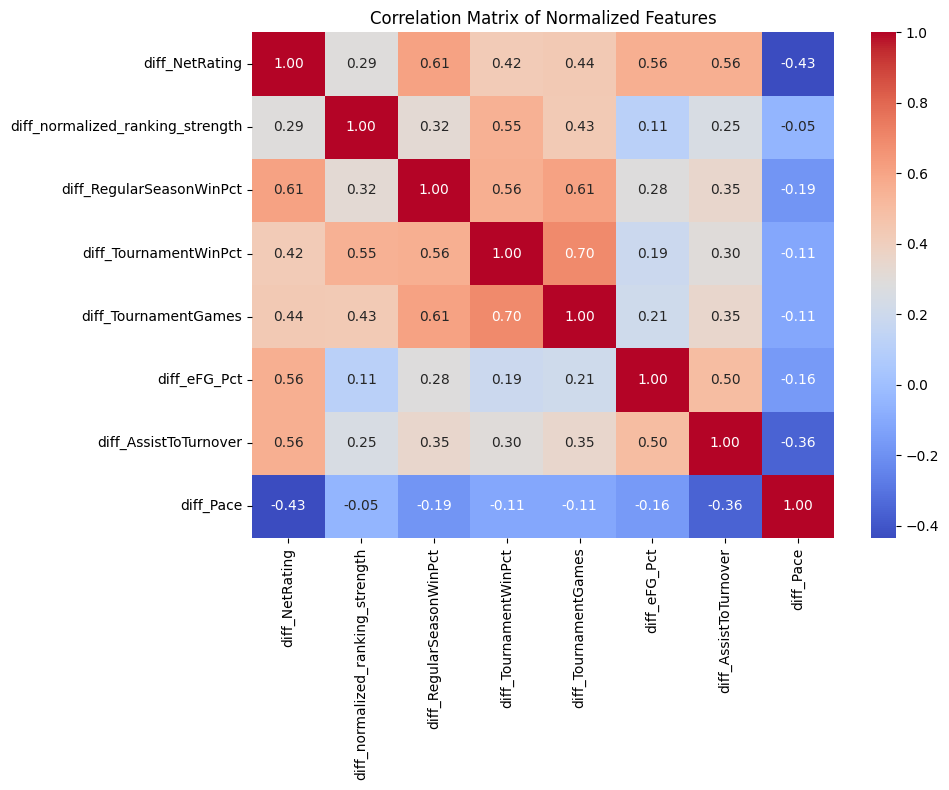

In [12]:
plt.figure(figsize=(10, 8))
correlation_matrix = X_train.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Normalized Features')
plt.tight_layout()
plt.savefig('feature_correlations.png')
# plt.close()

# print("\nData preparation complete. Ready for model development!")

Logistic Regression Modelling

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

In [14]:
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_val_prob = model.predict_proba(X_val)[:, 1]  # Probability of class 1

print("Training accuracy:", accuracy_score(y_train, y_train_pred))
print("Validation accuracy:", accuracy_score(y_val, y_val_pred))
print("Validation ROC AUC:", roc_auc_score(y_val, y_val_prob))
print("\nValidation Classification Report:")
print(classification_report(y_val, y_val_pred))

# Feature importance (coefficients)
coefficients = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': model.coef_[0]
})
print("\nTop 10 most important features:")
print(coefficients.sort_values(by='Coefficient', key=abs, ascending=False).head(10))

Training accuracy: 0.687960687960688
Validation accuracy: 0.5873015873015873
Validation ROC AUC: 0.6581196581196581

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.50      0.48        24
           1       0.68      0.64      0.66        39

    accuracy                           0.59        63
   macro avg       0.57      0.57      0.57        63
weighted avg       0.59      0.59      0.59        63


Top 10 most important features:
                            Feature  Coefficient
0                    diff_NetRating     0.766115
1  diff_normalized_ranking_strength     0.437763
4              diff_TournamentGames     0.154824
3             diff_TournamentWinPct     0.138033
2          diff_RegularSeasonWinPct     0.134257
5                      diff_eFG_Pct    -0.107425
7                         diff_Pace    -0.076129
6             diff_AssistToTurnover     0.006277


In [15]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# Dictionary to store results
results = {}

# Test different regularization strengths
for C_value in [0.01, 0.1, 1, 10, 100]:
    # Create and train model
    model = LogisticRegression(C=C_value, random_state=42, solver='liblinear', max_iter=1000)
    model.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_val_prob = model.predict_proba(X_val)[:, 1]
    
    # Store metrics
    results[C_value] = {
        'train_accuracy': accuracy_score(y_train, y_train_pred),
        'val_accuracy': accuracy_score(y_val, y_val_pred),
        'val_auc': roc_auc_score(y_val, y_val_prob),
        'model': model
    }

# Print comparison table
print("C Parameter Comparison:")
print("----------------------")
print(f"{'C':<8} {'Train Acc':<12} {'Val Acc':<12} {'ROC AUC':<12}")
print("-" * 44)
for C_value, metrics in results.items():
    print(f"{C_value:<8} {metrics['train_accuracy']:.4f}      {metrics['val_accuracy']:.4f}      {metrics['val_auc']:.4f}")

# Check best model based on validation AUC
best_C = max(results.keys(), key=lambda c: results[c]['val_auc'])
print(f"\nBest C value: {best_C} (Validation AUC: {results[best_C]['val_auc']:.4f})")

# Show feature importance for best model
coefficients = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': results[best_C]['model'].coef_[0]
})
print("\nTop 5 features for best model:")
print(coefficients.sort_values(by='Coefficient', key=abs, ascending=False).head(5))

C Parameter Comparison:
----------------------
C        Train Acc    Val Acc      ROC AUC     
--------------------------------------------
0.01     0.6896      0.6032      0.6517
0.1      0.6896      0.6032      0.6571
1        0.6880      0.5873      0.6581
10       0.6871      0.5873      0.6581
100      0.6871      0.5873      0.6581

Best C value: 10 (Validation AUC: 0.6581)

Top 5 features for best model:
                            Feature  Coefficient
0                    diff_NetRating     0.774688
1  diff_normalized_ranking_strength     0.439697
4              diff_TournamentGames     0.155802
3             diff_TournamentWinPct     0.136879
2          diff_RegularSeasonWinPct     0.132048


Training accuracy: 0.7641277641277642
Validation accuracy: 0.6349206349206349
Validation ROC AUC: 0.6848290598290597

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.62      0.57        24
           1       0.74      0.64      0.68        39

    accuracy                           0.63        63
   macro avg       0.63      0.63      0.63        63
weighted avg       0.65      0.63      0.64        63


Top 10 most important features:
                            Feature  Importance
0                    diff_NetRating    0.241608
2          diff_RegularSeasonWinPct    0.156566
4              diff_TournamentGames    0.154942
1  diff_normalized_ranking_strength    0.142339
3             diff_TournamentWinPct    0.140797
6             diff_AssistToTurnover    0.078917
7                         diff_Pace    0.056876
5                      diff_eFG_Pct    0.027955


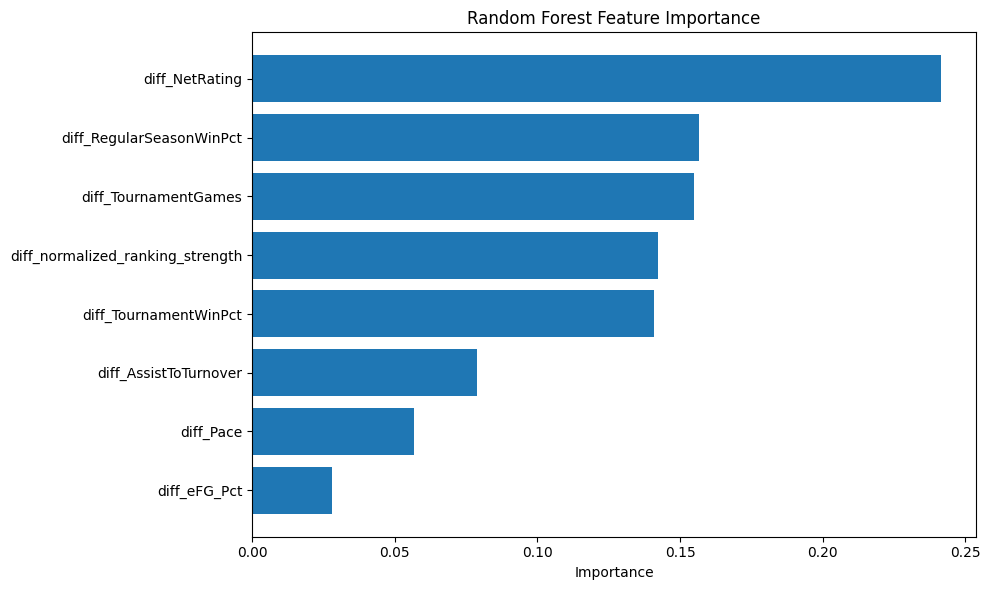

In [16]:
# Import necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Create and train a Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=100,  # Number of trees
    max_depth=5,    # Maximum depth of trees (None means unlimited)
    min_samples_split=10,
    random_state=42,
    n_jobs=-1          # Use all available cores
)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_train_pred = rf_model.predict(X_train)
y_val_pred = rf_model.predict(X_val)
y_val_prob = rf_model.predict_proba(X_val)[:, 1]  # Probability of class 1

# Evaluate performance
print("Training accuracy:", accuracy_score(y_train, y_train_pred))
print("Validation accuracy:", accuracy_score(y_val, y_val_pred))
print("Validation ROC AUC:", roc_auc_score(y_val, y_val_prob))
print("\nValidation Classification Report:")
print(classification_report(y_val, y_val_pred))

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
})

# Display top 10 features
print("\nTop 10 most important features:")
print(feature_importance.sort_values(by='Importance', ascending=False).head(10))

# Optional: Plot feature importance
plt.figure(figsize=(10, 6))
top_features = feature_importance.sort_values(by='Importance', ascending=False).head(10)
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel('Importance')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()  # Display the highest importance at the top
plt.tight_layout()
plt.show()